In [1]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
import sys
from datetime import datetime
sys.path.append("../")
sys.path.append("../../")
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "gpt2"

tokenizer_with_prefix_space = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=True, local_files_only = False)
tokenizer_without_prefix_space = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=False, local_files_only = False)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=tokenizer_with_prefix_space.eos_token_id).to(device)

/opt/conda/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
from gpt2.gpt2_probabilistic_model_wrapper import GPT2_probabilistic_model_wrapper
from guiding_wfa_teacher import alphabet
wrapper_with_prefix_space = GPT2_probabilistic_model_wrapper(50, alphabet, device, model, tokenizer_with_prefix_space)
wrapper_without_prefix_space = GPT2_probabilistic_model_wrapper(50, alphabet, device, model, tokenizer_without_prefix_space)


In [3]:
from guiding_wfa_teacher import get_teacher_wfa
from pythautomata.utilities.guiding_wfa_sequence_generator import GuidingWDFASequenceGenerator
guiding_wfa = get_teacher_wfa(wrapper_with_prefix_space.terminal_symbol)
guiding_generator = GuidingWDFASequenceGenerator(guiding_wfa, None)
guiding_generator.generate_words(7)

[ϵ,
 The teacher praised the student. ,He,was very proud of the ,boy,
 The teacher praised the student. ,She,
 The teacher praised the student. ,He,was very proud of the ,boy,
 The teacher praised the student. ,
 The teacher praised the student. ,
 The teacher praised the student. ]

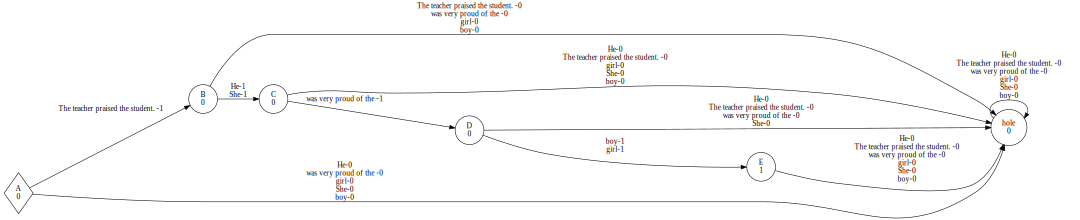

In [4]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(guiding_wfa)

display(graph)

In [5]:
exporter.export(guiding_wfa,"./")

In [6]:
from src.synchronic_model_guided_language_model import SynchronicModelGuidedLanguageModel

property_model = get_teacher_wfa(wrapper_with_prefix_space.terminal_symbol)
syncrhronic_model_with_prefix_space = SynchronicModelGuidedLanguageModel(wrapper_with_prefix_space, property_model, model_name="GUIDED_GPT2", max_seq_length=10,normalize_outputs=True, top_k = 2)
syncrhronic_model_without_prefix_space = SynchronicModelGuidedLanguageModel(wrapper_without_prefix_space, property_model, model_name="GUIDED_GPT2", max_seq_length=10,normalize_outputs=True, top_k = 2)

In [7]:
from pymodelextractor.teachers.pac_probabilistic_teacher import PACProbabilisticTeacher
from src.hypothesis_aware_sample_probabilistic_teacher import HypothesisAwareSampleProbabilisticTeacher
from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pythautomata.utilities.probability_partitioner import TopKProbabilityPartitioner, QuantizationProbabilityPartitioner, RankingPartitioner
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.uniform_word_sequence_generator import UniformWordSequenceGenerator


partitioner = QuantizationProbabilityPartitioner(100000)
comparator = WFAPartitionComparator(partitioner)
epsilon = 0.1
delta = epsilon
sequence_generator = guiding_generator
max_states = 30
max_query_length = 100


In [8]:
teacher_with_prefix_space = HypothesisAwareSampleProbabilisticTeacher(syncrhronic_model_with_prefix_space, 
                                                                      comparator, 30)
teacher_without_prefix_space = HypothesisAwareSampleProbabilisticTeacher(syncrhronic_model_without_prefix_space, 
                                                                         comparator, 30)

In [9]:
learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, 
                                                 max_states, 
                                                 max_query_length, 
                                                 max_seconds_run = None, 
                                                 generate_partial_hipothesis = True, 
                                                 pre_cache_queries_for_building_hipothesis = True,  
                                                 check_probabilistic_hipothesis = False, 
                                                 omit_zero_transitions=True)

In [10]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


Size before update: 6
CE: The teacher praised the student. ,She,was very proud of the 
----update_node----
Old Node (new Leaf) The teacher praised the student. ,He
New Leaf The teacher praised the student. ,She
dict_keys([The teacher praised the student. , ϵ, The teacher praised the student. ,He, The teacher praised the student. ,He,was very proud of the , The teacher praised the student. ,He,was very proud of the ,boy, The teacher praised the student. ,She,was very proud of the ])
dict_keys([The teacher praised the student. , ϵ, The teacher praised the student. ,He, The teacher praised the student. ,He,was very proud of the , The teacher praised the student. ,He,was very proud of the ,boy, The teacher praised the student. ,She,was very proud of the , The teacher praised the student. ,She])
--------
Size after update: 8


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


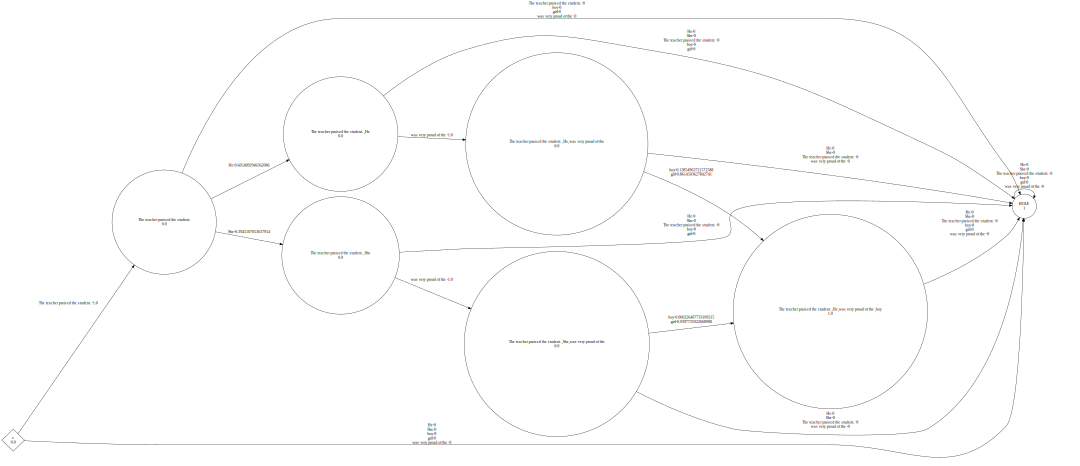

In [11]:
learning_result_with_prefix_space = learner.learn(teacher_with_prefix_space, verbose = True)
exporter = WFADotExportingStrategy()
actual_date = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
exporter.export(learning_result_with_prefix_space.model,"./", "pdfa_engineer_with_prefix_"+actual_date)
graph1 = exporter.create_graph(learning_result_with_prefix_space.model)
display(graph1)

Size before update: 6
CE: The teacher praised the student. ,She,was very proud of the 
----update_node----
Old Node (new Leaf) The teacher praised the student. ,He
New Leaf The teacher praised the student. ,She
dict_keys([The teacher praised the student. , ϵ, The teacher praised the student. ,He, The teacher praised the student. ,He,was very proud of the , The teacher praised the student. ,He,was very proud of the ,boy, The teacher praised the student. ,She,was very proud of the ])
dict_keys([The teacher praised the student. , ϵ, The teacher praised the student. ,He, The teacher praised the student. ,He,was very proud of the , The teacher praised the student. ,He,was very proud of the ,boy, The teacher praised the student. ,She,was very proud of the , The teacher praised the student. ,She])
--------
Size after update: 8


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


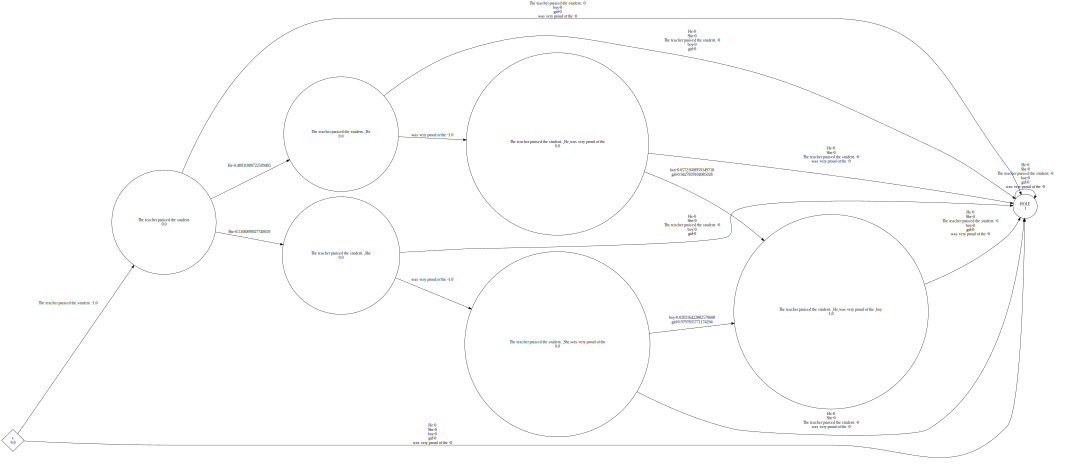

In [12]:
learning_result_without_prefix_space = learner.learn(teacher_without_prefix_space, verbose = True)

exporter = WFADotExportingStrategy()
actual_date = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
graph2 = exporter.create_graph(learning_result_without_prefix_space.model)
exporter.export(learning_result_without_prefix_space.model, "./", "pdfa_engineer_without_prefix_"+actual_date)
display(graph2)

In [13]:
pdfa_with = learning_result_with_prefix_space.model
from pythautomata.utilities.pdfa_operations import get_representative_sample

for i in range(1000):        
        number = get_representative_sample(pdfa_with, sample_size = 1)
        print(number)

[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,boy]
[The teacher praised the student. ,He,was very proud of the ,boy]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,boy]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the 

[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,boy]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,boy]
[The teacher praised the student. ,He,was very proud of the 

[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of th

In [14]:
pdfa_without = learning_result_without_prefix_space.model
from pythautomata.utilities.pdfa_operations import get_representative_sample

for i in range(1000):        
        number = get_representative_sample(pdfa_without, sample_size = 1)
        print(number)

[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,boy]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,boy]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of

[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud

[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,boy]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of

[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud of the ,girl]
[The teacher praised the student. ,She,was very proud of the ,girl]
[The teacher praised the student. ,He,was very proud o